In [1]:
import nltk
import pandas as pd
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import csv
import requests
from io import StringIO
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB
from tensorflow.python.keras.layers import Dropout

In [2]:
df = pd.read_csv('app_reviews.csv')
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,803e8384-434e-44e3-89c0-c2234ec530b0,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"aplikasi tidak bisa dipakai sama sekali, mau l...",1,12,2.0.27,2025-05-14 10:21:27,NaN,NaN,2.0.27
1,deacf44d-8f4d-47f6-8a7b-eef00f023a67,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"halo segi keamanan aplikasi oke, ui ux nya bag...",2,32,2.0.27,2025-05-04 20:16:39,"Hai kak mohon maaf atas kendalanya, saat ini k...",2025-05-16 14:28:43,2.0.27
2,691746d1-202c-4bf3-b545-eac327b5cbe1,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"aneh banget jaringan wifi lancar, sinyal bagus...",1,58,2.0.27,2025-04-28 11:15:34,"Hai kak mohon maaf atas kendalanya, saat ini k...",2025-04-28 16:07:23,2.0.27
3,f8b4ccbd-f5e7-4729-90a6-8f4ce50f340a,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Tolong bapak, di tingkatkan lagi aplikasinya, ...",1,232,2.0.27,2025-05-04 19:17:21,Hai kak kami mohon maaf atas kendala yang kamu...,2025-05-16 14:29:39,2.0.27
4,7a476202-ada5-4bbb-88f1-d125cf739188,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Aplikasinya terlalu bikin repot, saya buat skc...",2,156,2.0.27,2025-05-01 21:42:14,"Hai kak mohon maaf atas ketidaknyamanannya, sa...",2025-05-02 16:42:41,2.0.27


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17866 entries, 0 to 17865
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              17866 non-null  object
 1   userName              17866 non-null  object
 2   userImage             17866 non-null  object
 3   content               17866 non-null  object
 4   score                 17866 non-null  int64 
 5   thumbsUpCount         17866 non-null  int64 
 6   reviewCreatedVersion  15610 non-null  object
 7   at                    17866 non-null  object
 8   replyContent          16772 non-null  object
 9   repliedAt             16772 non-null  object
 10  appVersion            15610 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.5+ MB


In [4]:
df.dropna(inplace=True)

In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14665 entries, 1 to 17482
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              14665 non-null  object
 1   userName              14665 non-null  object
 2   userImage             14665 non-null  object
 3   content               14665 non-null  object
 4   score                 14665 non-null  int64 
 5   thumbsUpCount         14665 non-null  int64 
 6   reviewCreatedVersion  14665 non-null  object
 7   at                    14665 non-null  object
 8   replyContent          14665 non-null  object
 9   repliedAt             14665 non-null  object
 10  appVersion            14665 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


### Preprocessing Text

In [7]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip(' ')
    return text

def casefoldingText(text):
    text = text.lower()
    return text

def tokenizingText(text):
    text = word_tokenize(text)
    return text

def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update([
        'iya','yaa','gak','nya','na','sih','ku','di','ga','ya','gaa','loh',
        'kah','woi','woii','woy', 'aja', 'banget', 'dong', 'nih', 'deh', 'tuh', 'kan',
        'si', 'lu', 'lo', 'gue', 'gw', 'kok', 'eh', 'hmm', 'huhu', 'hehe', 'haha',
        'hahaha', 'wkwk', 'wkwkwk', 'anjir', 'anjay', 'bro', 'sis', 'mantul', 'btw',
        'cmn', 'cuma', 'bgt', 'jd', 'jg', 'trs', 'bikin', 'sampe', 'dah', 'udah',
        'udahh', 'udh', 'pdhl', 'tp', 'tapi', 'makasih', 'thx', 'thanks', 'terima', 'kasih'
    ])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aodih\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aodih\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\aodih\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [8]:
slangwords = {"abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "gk": "nggak", "ga": "nggak", "gak": "nggak", "ngga": "nggak", "tdk": "tidak", "tk": "tidak", "tpi": "tapi", "tp": "tapi", "udh": "sudah", "udah": "sudah", "dah": "sudah", "blm": "belum", "krn": "karena", "karna": "karena", "dr": "dari", "sm": "sama", "sama2": "sama-sama", "lg": "lagi", "jg": "juga", "jga": "juga", "aja": "saja", "aj": "saja", "dgn": "dengan", "dg": "dengan", "sy": "saya", "sya": "saya", "gw": "saya", "gua": "saya", "gue": "saya", "ane": "saya", "lu": "kamu", "lo": "kamu", "elo": "kamu", "km": "kamu", "kmu": "kamu", "loe": "kamu", "trus": "terus", "trs": "terus", "klo": "kalau", "klu": "kalau", "kl": "kalau", "klw": "kalau", "kalo": "kalau", "blg": "bilang", "omg": "ya ampun", "pls": "tolong", "plis": "tolong", "bsk": "besok", "besk": "besok", "bner": "benar", "bener": "benar", "bgtu": "begitu", "bgitu": "begitu", "btw": "ngomong-ngomong", "td": "tadi",  "ntar": "nanti", "nnti": "nanti", "pgn": "pingin", "pengen": "ingin", "bikin": "membuat", "dpt": "dapat", "dptin": "dapatkan", "ntr": "nanti", "jd": "jadi", "jdnya": "jadinya"}

def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [9]:
to_df = df.copy()
to_df['text_clean'] = to_df['content'].apply(cleaningText)
to_df['text_casefolding'] = to_df['text_clean'].apply(casefoldingText)
to_df['text_slangwords'] = to_df['text_casefolding'].apply(fix_slangwords)
to_df['text_tokenizing'] = to_df['text_slangwords'].apply(tokenizingText)
to_df['text_stopword'] = to_df['text_tokenizing'].apply(filteringText)
to_df['text_fin'] = to_df['text_stopword'].apply(toSentence)
to_df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_clean,text_casefolding,text_slangwords,text_tokenizing,text_stopword,text_fin
1,deacf44d-8f4d-47f6-8a7b-eef00f023a67,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"halo segi keamanan aplikasi oke, ui ux nya bag...",2,32,2.0.27,2025-05-04 20:16:39,"Hai kak mohon maaf atas kendalanya, saat ini k...",2025-05-16 14:28:43,2.0.27,halo segi keamanan aplikasi oke ui ux nya bagu...,halo segi keamanan aplikasi oke ui ux nya bagu...,halo segi keamanan aplikasi oke ui ux nya bagu...,"[halo, segi, keamanan, aplikasi, oke, ui, ux, ...","[halo, segi, keamanan, aplikasi, oke, ui, ux, ...",halo segi keamanan aplikasi oke ui ux bagus pe...
2,691746d1-202c-4bf3-b545-eac327b5cbe1,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"aneh banget jaringan wifi lancar, sinyal bagus...",1,58,2.0.27,2025-04-28 11:15:34,"Hai kak mohon maaf atas kendalanya, saat ini k...",2025-04-28 16:07:23,2.0.27,aneh banget jaringan wifi lancar sinyal bagus ...,aneh banget jaringan wifi lancar sinyal bagus ...,aneh banget jaringan wifi lancar sinyal bagus ...,"[aneh, banget, jaringan, wifi, lancar, sinyal,...","[aneh, jaringan, wifi, lancar, sinyal, bagus, ...",aneh jaringan wifi lancar sinyal bagus kuota k...
3,f8b4ccbd-f5e7-4729-90a6-8f4ce50f340a,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Tolong bapak, di tingkatkan lagi aplikasinya, ...",1,232,2.0.27,2025-05-04 19:17:21,Hai kak kami mohon maaf atas kendala yang kamu...,2025-05-16 14:29:39,2.0.27,Tolong bapak di tingkatkan lagi aplikasinya sa...,tolong bapak di tingkatkan lagi aplikasinya sa...,tolong bapak di tingkatkan lagi aplikasinya sa...,"[tolong, bapak, di, tingkatkan, lagi, aplikasi...","[tolong, tingkatkan, aplikasinya, simpan, data...",tolong tingkatkan aplikasinya simpan data skck...
4,7a476202-ada5-4bbb-88f1-d125cf739188,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Aplikasinya terlalu bikin repot, saya buat skc...",2,156,2.0.27,2025-05-01 21:42:14,"Hai kak mohon maaf atas ketidaknyamanannya, sa...",2025-05-02 16:42:41,2.0.27,Aplikasinya terlalu bikin repot saya buat skck...,aplikasinya terlalu bikin repot saya buat skck...,aplikasinya terlalu membuat repot saya buat sk...,"[aplikasinya, terlalu, membuat, repot, saya, b...","[aplikasinya, repot, skck, bayar, polsek, yg, ...",aplikasinya repot skck bayar polsek yg jarakny...
5,89b1ee2a-4180-44c6-bb5e-a0df0a8a5f19,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Gak bisa dipakai, ke polsek mau bikin skck off...",1,151,2.0.27,2025-04-21 12:57:05,Hai kak kami mohon maaf atas kendala yang kamu...,2025-04-28 14:40:19,2.0.27,Gak bisa dipakai ke polsek mau bikin skck offl...,gak bisa dipakai ke polsek mau bikin skck offl...,nggak bisa dipakai ke polsek mau membuat skck ...,"[nggak, bisa, dipakai, ke, polsek, mau, membua...","[nggak, dipakai, polsek, skck, offline, daftar...",nggak dipakai polsek skck offline daftar onlin...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17478,3e41a5e3-27f2-4969-9c88-463ba4beb8ea,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Sangat terbantuu,5,0,1.0.15,2022-06-27 17:46:45,"Hai kak eva yunita, Terima kasih ya atas keper...",2022-07-13 14:28:10,1.0.15,Sangat terbantuu,sangat terbantuu,sangat terbantuu,"[sangat, terbantuu]",[terbantuu],terbantuu
17479,8d94ef11-d4a5-42c9-ad36-a3e473cd01c5,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Paspor, npwp, skck online, sim, stnk",1,0,1.0.13,2022-06-21 01:38:52,"Hai Anugrah Cehenel, kami mohon maaf atas kend...",2022-07-03 00:46:02,1.0.13,Paspor npwp skck online sim stnk,paspor npwp skck online sim stnk,paspor npwp skck online sim stnk,"[paspor, npwp, skck, online, sim, stnk]","[paspor, npwp, skck, online, sim, stnk]",paspor npwp skck online sim stnk
17480,3af708d5-9f4e-4636-9b7b-3a9177a74a5b,Pengguna Google,https:/

### Labeling

In [10]:
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')

    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")

lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')


if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')

    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")

In [11]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    for word in text:
        if word in lexicon_positive:
            score += lexicon_positive[word]
        elif word in lexicon_negative:
            score += lexicon_negative[word]
    if score > 0:
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

In [12]:
results = to_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
to_df['polarity_score'] = results[0]
to_df['polarity'] = results[1]

print(to_df['polarity'].value_counts())

polarity
positive    7279
negative    5230
neutral     2156
Name: count, dtype: int64


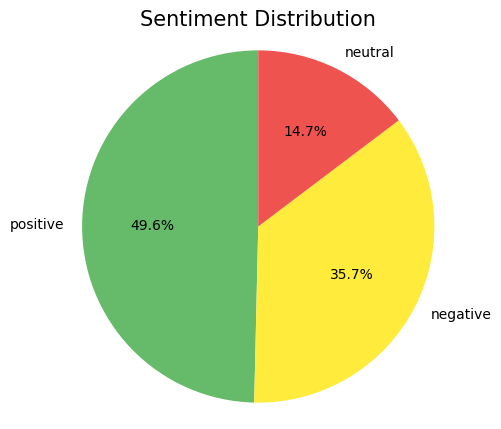

In [13]:
labels = ["positive", "negative", "neutral"]
sizes = [i for i in to_df['polarity'].value_counts()]
colors = ['#66bb6a', '#ffeb3b', '#ef5350']

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Sentiment Distribution', fontsize=15)
plt.axis('equal')
plt.show()

### Data splitting and feature extraction

In [14]:
X = to_df['text_fin']
y = to_df['polarity']

tfidf = TfidfVectorizer(max_features=700, min_df=17, max_df=0.8)
x_tfidf = tfidf.fit_transform(X)

features_df = pd.DataFrame(x_tfidf.toarray(), columns=tfidf.get_feature_names_out())
features_df

,ad,admin,administrasi,ajukan,akses,aktif,akun,alamat,alasan,alhamdulillah,...,wa,wajah,wajib,warga,web,website,wifi,wilayah,yah,yg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.178671,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.204821,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.113841
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.181815,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
14661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
14662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
14663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


### Modelling

In [15]:
X_train, X_test, y_train, y_test = train_test_split(x_tfidf, y, test_size=0.2, random_state=42)

#### Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression()

logistic_regression.fit(X_train.toarray(), y_train)

y_pred_train_lr = logistic_regression.predict(X_train.toarray())
y_pred_test_lr = logistic_regression.predict(X_test.toarray())

accuracy_train_lr = accuracy_score(y_pred_train_lr, y_train)

accuracy_test_lr = accuracy_score(y_pred_test_lr, y_test)

print('Logistic Regression - accuracy_train:', accuracy_train_lr)
print('Logistic Regression - accuracy_test:', accuracy_test_lr)

Logistic Regression - accuracy_train: 0.9099897715649505
Logistic Regression - accuracy_test: 0.8915785884759632


#### CNN

In [17]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

max_words = to_df['text_fin'].str.split().str.len().max()

tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(to_df['text_fin'])
sequences = tokenizer.texts_to_sequences(to_df['text_fin'])
word_index = tokenizer.word_index

y = to_df['polarity'].map({'positive': 2, 'negative': 0, 'neutral': 1})
X = pad_sequences(sequences, maxlen=max_words)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    Embedding(1000, 64),
    Conv1D(64, 2, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(10, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=3, validation_data=(X_test, y_test))

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

y_pred_train_labels = np.argmax(y_pred_train, axis=1)
y_pred_test_labels = np.argmax(y_pred_test, axis=1)

accuracy_train = accuracy_score(y_train, y_pred_train_labels)
accuracy_test = accuracy_score(y_test, y_pred_test_labels)
print('accuracy_train:', accuracy_train)
print('accuracy_test:', accuracy_test)

Epoch 1/10
3911/3911 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6890 - loss: 0.7261 - val_accuracy: 0.8466 - val_loss: 0.4309
Epoch 2/10
3911/3911 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8449 - loss: 0.4337 - val_accuracy: 0.8623 - val_loss: 0.3864
Epoch 3/10
3911/3911 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8576 - loss: 0.3886 - val_accuracy: 0.8646 - val_loss: 0.3895
Epoch 4/10
3911/3911 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8745 - loss: 0.3532 - val_accuracy: 0.8650 - val_loss: 0.3763
Epoch 5/10
3911/3911 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8839 - loss: 0.3185 - val_accuracy: 0.8701 - val_loss: 0.3839
Epoch 6/10
3911/3911 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8970 - loss: 0.2886 - val_accuracy: 0.8663 - val_loss: 0.3916
Epoch 7/10
3911/3911 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9020 - loss: 0.2756 - val_accuracy: 0.8704 - val_loss: 0.3916
Epoch 8/10
3911/3911 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9141 - loss: 0.2485 - 